In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

### 1.1 Metadata EDA 

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df_o = all_xray_df
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
50378,00012753_002.png,Edema|Infiltration,2,12753,62,F,PA,2992,2991,0.143,0.143,NaN
5162,00001376_008.png,Pneumothorax,8,1376,50,M,AP,2500,2048,0.168,0.168,NaN
75197,00018448_017.png,No Finding,17,18448,42,M,PA,2992,2991,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5055,00026836_001.png,No Finding,1,26836,032Y,M,AP,3056,2544,0.139,0.139
3342,00016508_012.png,Consolidation|Pneumonia,12,16508,051Y,F,AP,2500,2048,0.168,0.168
2310,00011785_002.png,No Finding,2,11785,016Y,M,AP,2500,2048,0.168,0.168


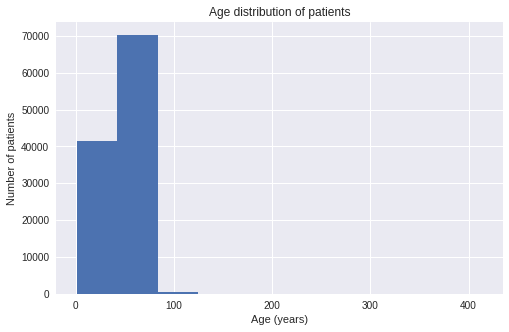

In [4]:
## Age distribution of patients
plt.style.use("seaborn")

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(all_xray_df["Patient Age"]);
ax.set(title="Age distribution of patients",
      xlabel="Age (years)",
      ylabel="Number of patients");

In [5]:
# The histogram above shows a strange distribution, thus it is important to check potential outliers
age_outliers1 = len(all_xray_df[all_xray_df["Patient Age"] > 120])
age_outliers1

16

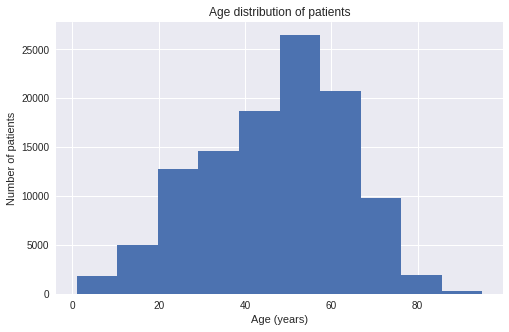

In [6]:
# Patients with age > 120 years old were misslabeled. Since there are only 16 patients and to avoid further problems,
# these patient's data will be removed from the array
all_xray_df = all_xray_df[all_xray_df["Patient Age"] < 120]

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(all_xray_df["Patient Age"]);
ax.set(title="Age distribution of patients",
      xlabel="Age (years)",
      ylabel="Number of patients");

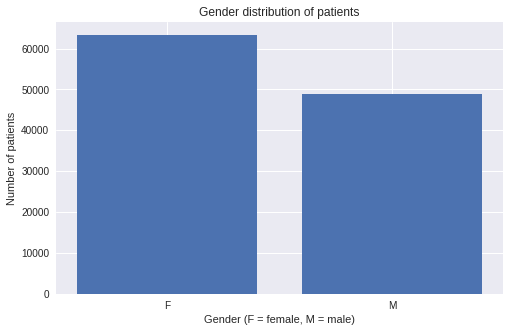

In [7]:
# Gender distribution

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(np.unique(all_xray_df["Patient Gender"]), all_xray_df["Patient Gender"].value_counts());
ax.set(title="Gender distribution of patients",
      xlabel="Gender (F = female, M = male)",
      ylabel="Number of patients");

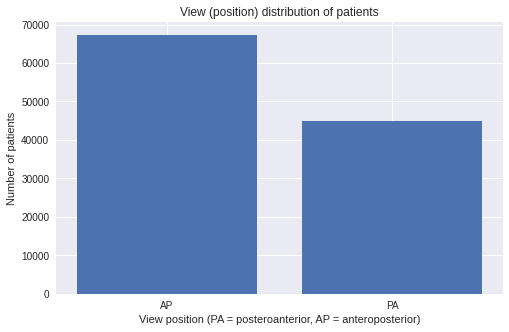

In [8]:
# The x-ray views taken (i.e. view position)

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(np.unique(all_xray_df["View Position"]), all_xray_df["View Position"].value_counts());
ax.set(title="View (position) distribution of patients",
      xlabel="View position (PA = posteroanterior, AP = anteroposterior)",
      ylabel="Number of patients");

In [9]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
89095,00022115_000.png,No Finding,0,22115,41,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
62443,00015444_001.png,No Finding,1,15444,49,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28073,00007321_002.png,No Finding,2,7321,57,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


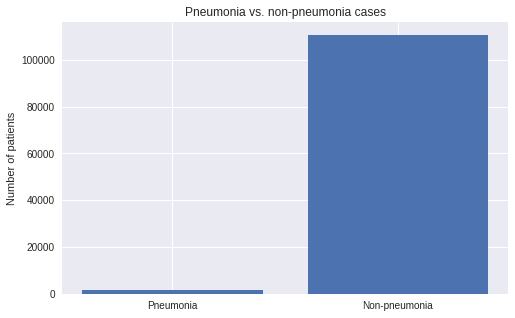

In [10]:
# Pneumonia vs. non-pneumonia cases

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(["Pneumonia", "Non-pneumonia"], ((all_xray_df["Pneumonia"]==1).sum(), (all_xray_df["Pneumonia"]==0).sum()));
ax.set(title="Pneumonia vs. non-pneumonia cases",
      ylabel="Number of patients");

In [11]:
# Distribution of pneumonia (1.2%) vs. non pneumonia (98%) cases
(all_xray_df["Pneumonia"]==1).sum()/len(all_xray_df), (all_xray_df["Pneumonia"]==0).sum()/len(all_xray_df)

(0.012756012274316705, 0.9872439877256833)

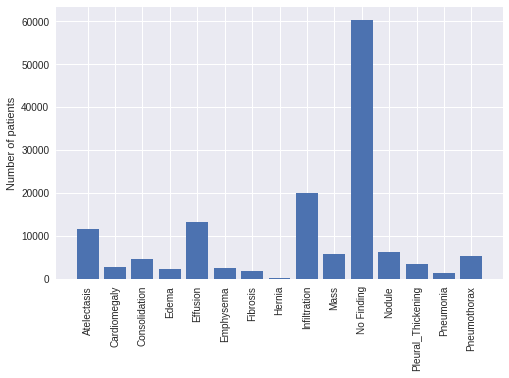

In [12]:
# Finding labels: No findings, pneumonia and other diseases
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(all_labels, all_xray_df[all_labels].sum())
plt.xticks(rotation=90)
ax.set(ylabel="Number of patients");

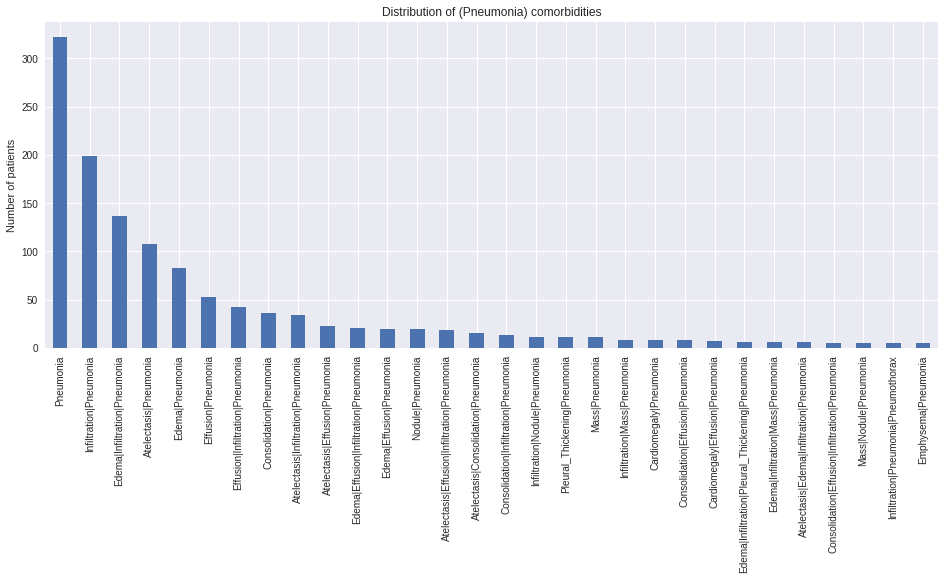

In [13]:
# Distribution of (Pneumonia) comorbidities 

fig, ax = plt.subplots(figsize=(16, 6))
all_xray_df[all_xray_df.Pneumonia == 1]["Finding Labels"].value_counts()[:30].plot(kind="bar");
ax.set(title="Distribution of (Pneumonia) comorbidities",
      ylabel = "Number of patients");

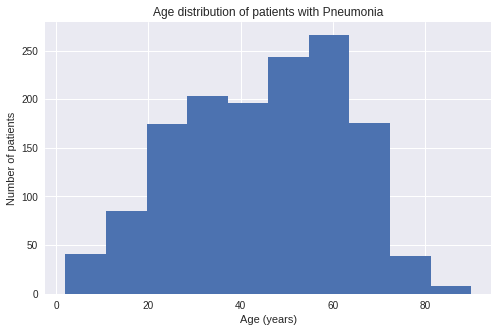

In [14]:
# Age distribution of patients with Pneumonia

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(all_xray_df[all_xray_df.Pneumonia == 1]["Patient Age"]);
ax.set(title="Age distribution of patients with Pneumonia",
       xlabel="Age (years)",
       ylabel="Number of patients");

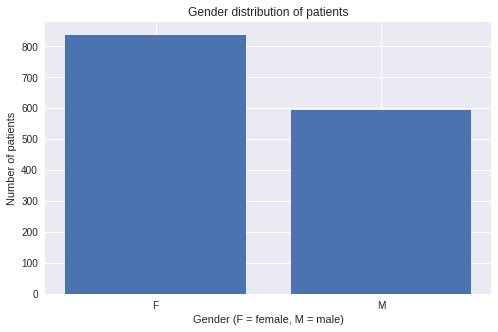

In [15]:
# Gender distribution of patients with Pneumonia

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(np.unique(all_xray_df[all_xray_df.Pneumonia == 1]["Patient Gender"]), all_xray_df[all_xray_df.Pneumonia == 1]["Patient Gender"].value_counts());
ax.set(title="Gender distribution of patients",
      xlabel="Gender (F = female, M = male)",
      ylabel="Number of patients");

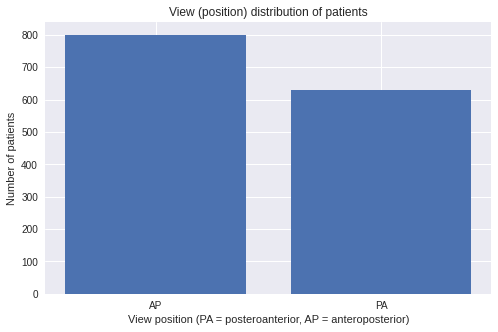

In [16]:
# The x-ray views taken (i.e. view position) in pneumonia patients

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(np.unique(all_xray_df[all_xray_df.Pneumonia == 1]["View Position"]), all_xray_df[all_xray_df.Pneumonia == 1]["View Position"].value_counts());
ax.set(title="View (position) distribution of patients",
      xlabel="View position (PA = posteroanterior, AP = anteroposterior)",
      ylabel="Number of patients");

### 1.2 Pixel-level EDA

In [17]:
len(sample_df)

5606

In [18]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [19]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


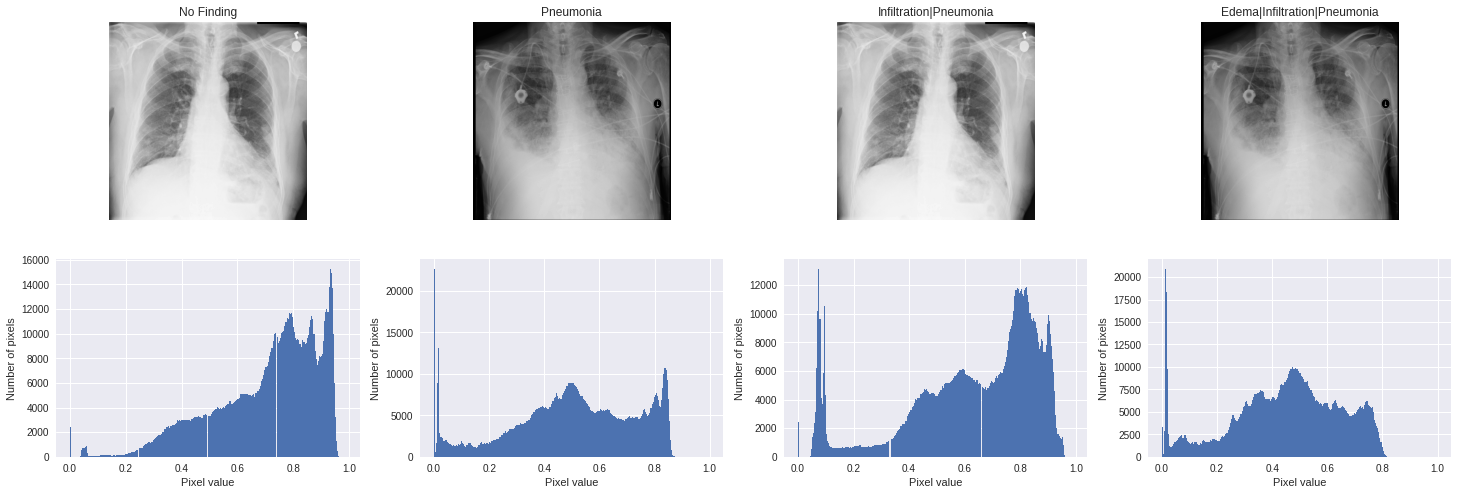

In [20]:
# The file sampe_df contains Image Index values that do not appear in the database, showing an error when those files are plotted,
# thus the original database is selected instead

fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7)) = plt.subplots(nrows=2,
                                                                 ncols=4,
                                                                 figsize=(25, 8))

img0 = plt.imread("/data/images_001/images/{}".format(all_xray_df_o["Image Index"][all_xray_df_o[all_xray_df_o["Finding Labels"] == "No Finding"].index[0]]))
img1 = plt.imread("/data/images_001/images/{}".format(all_xray_df_o["Image Index"][all_xray_df_o[all_xray_df_o["Finding Labels"] == "Pneumonia"].index[0]]))
img2 = plt.imread("/data/images_001/images/{}".format(all_xray_df_o["Image Index"][all_xray_df_o[all_xray_df_o["Finding Labels"] == "Infiltration|Pneumonia"].index[0]]))
img3 = plt.imread("/data/images_001/images/{}".format(all_xray_df_o["Image Index"][all_xray_df_o[all_xray_df_o["Finding Labels"] == "Edema|Infiltration|Pneumonia"].index[0]]))


ax0.imshow(img0, cmap="gray")
ax1.imshow(img1, cmap="gray")
ax2.imshow(img0, cmap="gray")
ax3.imshow(img1, cmap="gray")
ax0.axis("Off")
ax1.axis("Off")
ax2.axis("Off")
ax3.axis("Off")
ax4.hist(img0.ravel(),bins=256)
ax5.hist(img1.ravel(),bins=256)
ax6.hist(img2.ravel(),bins=256)
ax7.hist(img3.ravel(),bins=256)
ax0.set(title="No Finding")
ax1.set(title="Pneumonia")
ax2.set(title="Infiltration|Pneumonia")
ax3.set(title="Edema|Infiltration|Pneumonia")
ax4.set(xlabel="Pixel value",
        ylabel="Number of pixels")
ax5.set(xlabel="Pixel value",
        ylabel="Number of pixels")
ax6.set(xlabel="Pixel value",
        ylabel="Number of pixels")
ax7.set(xlabel="Pixel value",
        ylabel="Number of pixels");

In [ ]:
# Conclusions:
# 1. Distribution of cases is unbalanced for pneumonia, thus training cases will be reduced
# 2. Important comorbidities of pneumonia are infiltration, edema, atelectasis and effusion. Performance could be impacted by
# the inclusion of these comorbidities (similar histograms)
# 3. Age, gender and view position distributions show real trends